In [1]:
import numpy as np
import csv
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
with open("D://3d Scan/POS1.txt") as file:
    reader = csv.reader(file, delimiter=',')
    Data = [row for row in reader]
    Data = np.array(Data)

XYZ = Data[:,:3]
color = Data[:,3:]
assert XYZ.shape == color.shape
print(np.average(XYZ.astype('float'), axis = 0))

[0.0023603  0.06593377 1.27778791]


In [3]:
ds = o3d.geometry.PointCloud()
ds.points = o3d.utility.Vector3dVector(XYZ)
ds.colors = o3d.utility.Vector3dVector(color)

In [ ]:
o3d.visualization.draw_geometries([ds])

In [4]:
voxel_down_ds = ds.voxel_down_sample(voxel_size=0.0002)
o3d.visualization.draw_geometries([voxel_down_ds])

In [32]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])
    
    
print("Statistical oulier removal")
cl, ind = voxel_down_ds.remove_statistical_outlier(nb_neighbors=20,
                                                    std_ratio=2)
display_inlier_outlier(voxel_down_ds, ind)

Statistical oulier removal
Showing outliers (red) and inliers (gray): 


In [ ]:
## Calculte axis alligned and oriented bounding box
aabb = cl.get_axis_aligned_bounding_box()
obb = cl.get_oriented_bounding_box()
obb.color = (0, 0.71, 0.129)
aabb.color = (1, 0, 0.788)
o3d.visualization.draw_geometries([cl, aabb, obb])

In [6]:
## Calculate convex Hull
hull, _ = cl.compute_convex_hull()
hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
hull_ls.paint_uniform_color((1, 0, 0))
o3d.visualization.draw_geometries([cl, hull_ls])

In [21]:
## ALPHA hull reconstruction

tetra_mesh, pt_map = o3d.geometry.TetraMesh.create_from_point_cloud(cl)
for alpha in np.logspace(np.log10(0.2), np.log10(0.001), num=5):
    print(f"alpha={alpha:.3f}")
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(
        cl, alpha, tetra_mesh, pt_map)
    mesh.compute_vertex_normals()
    o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

alpha=0.200
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
alpha=0.053
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
alpha=0.014
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
alpha=0.004
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
alpha=0.001
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh


In [34]:
import matplotlib.pyplot as plt
def custom_draw_geometry_with_key_callback(pcd):

    def change_background_to_black(vis):
        opt = vis.get_render_option()
        opt.background_color = np.asarray([0, 0, 0])
        return False
    
    def change_background_to_white(vis):
        opt = vis.get_render_option()
        opt.background_color = np.asarray([1,1,1])
        return False
    
    def capture_depth(vis):
        depth = vis.capture_depth_float_buffer()
        plt.imshow(np.asarray(depth))
        plt.show()
        return False

    key_to_callback = {}
    key_to_callback[ord("K")] = change_background_to_black
    key_to_callback[ord("I")] = change_background_to_white
    key_to_callback[ord(",")] = capture_depth
    o3d.visualization.draw_geometries_with_key_callbacks([pcd], key_to_callback)

[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.
[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


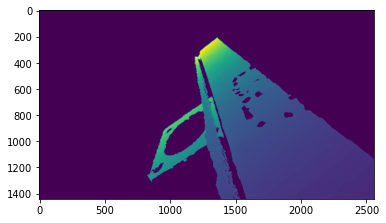

[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


In [35]:
alpha = 0.001
tetra_mesh, pt_map = o3d.geometry.TetraMesh.create_from_point_cloud(cl)
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(
    cl, alpha, tetra_mesh, pt_map)
mesh.compute_vertex_normals()
custom_draw_geometry_with_key_callback(mesh)

In [40]:
XYZ = XYZ.astype('float')
voxel_size=0.002
nb_vox=np.ceil((np.max(XYZ, axis=0) - np.min(XYZ, axis=0))/voxel_size)

In [42]:
non_empty_voxel_keys, inverse, nb_pts_per_voxel = np.unique(((XYZ - np.min(XYZ, axis=0)) // voxel_size).astype(int), axis=0, return_inverse=True, return_counts=True)
idx_pts_vox_sorted=np.argsort(inverse)

In [49]:
voxel_grid={}
grid_barycenter,grid_candidate_center=[],[]
last_seen=0

for idx,vox in enumerate(non_empty_voxel_keys):
    voxel_grid[tuple(vox)]= XYZ[idx_pts_vox_sorted[last_seen:last_seen+nb_pts_per_voxel[idx]]]
    grid_barycenter.append(np.mean(voxel_grid[tuple(vox)],axis=0))
    
    grid_candidate_center.append(voxel_grid[tuple(vox)][np.linalg.norm(voxel_grid[tuple(vox)] - np.mean(voxel_grid[tuple(vox)],axis=0),axis=1).argmin()])
    
    last_seen+=nb_pts_per_voxel[idx]

In [58]:
grid_barycenter = np.array(grid_barycenter)

In [63]:
grid_barycenter.shape

(3987, 3)

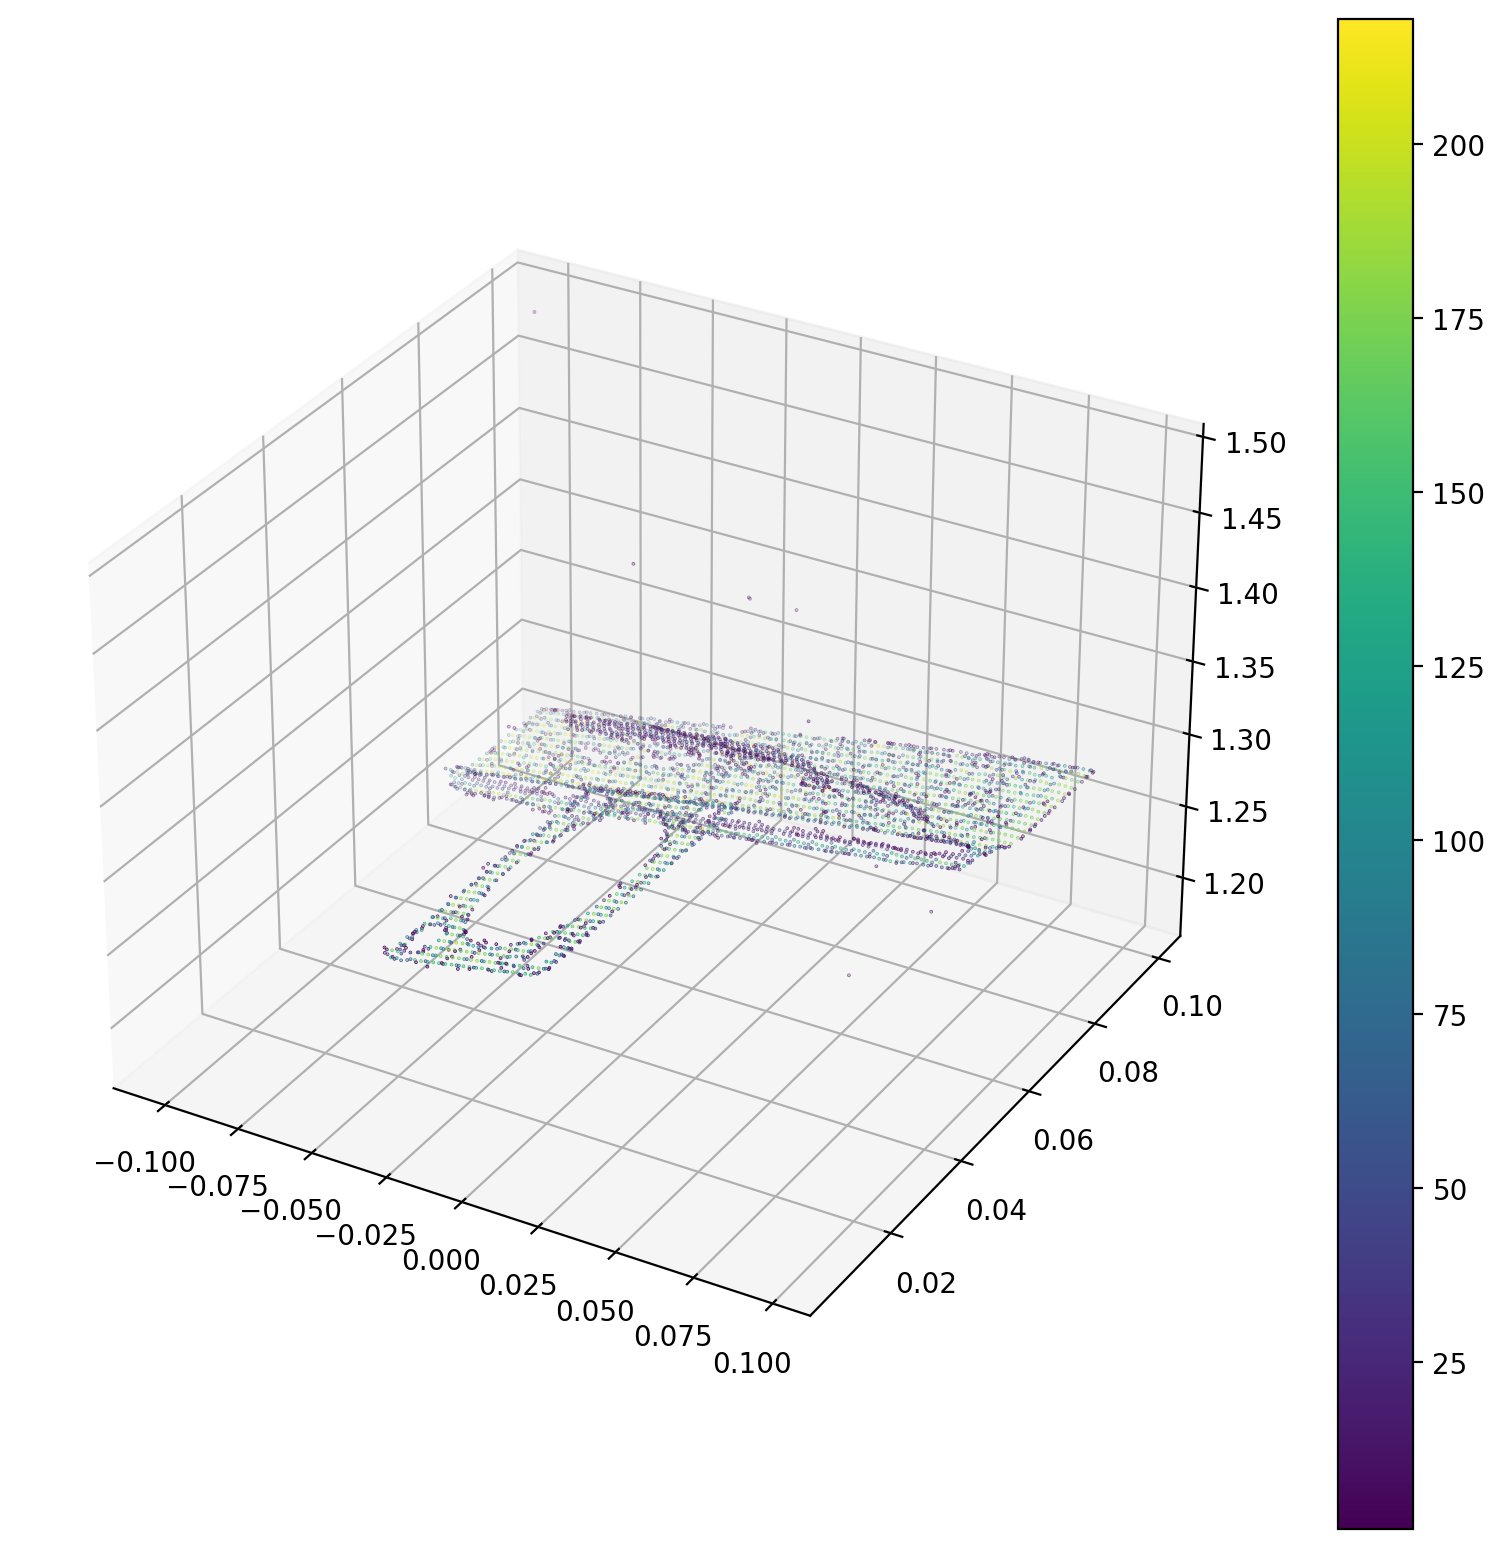

In [66]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.figure(figsize = (10,10), dpi = 200)
ax = plt.axes(projection='3d')
img = ax.scatter(grid_barycenter[:,0], grid_barycenter[:,1], grid_barycenter[:,2], c= nb_pts_per_voxel,s=0.1)
plt.colorbar(img)
plt.show()